In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon
import pickle 
import cv2 as cv

from src.vican.vican.cam import estimate_pose_mp, estimate_pose_charuco_worker
from src.vican.vican.bipgo import bipartite_se3sync, object_bipartite_se3sync
from src.vican.vican.plot import plot2D, plot_cams_3D
from src.vican.vican.dataset import Dataset

# Edit path to the folder containing the renders
DATASET_PATH = "./dataset/optitrack_videos/output_frames"
#DATASET_PATH= "./dataset/big_dataset"

# Edit path to the folder containing the cube calibration images.
OBJ_DATASET_PATH = "./dataset/realsense_charuco_object"
#OBJ_DATASET_PATH = "./dataset/big_dataset_object"

LOAD = True

dataset     = Dataset(root=DATASET_PATH)
obj_dataset = Dataset(root=OBJ_DATASET_PATH)

# TODO: why??


len(dataset.im_data["filename"])

5814

# Use below to rename object calib files (if needed) !!

In [2]:
""" import os
from PIL import Image
import os

# fix object image names

folders = os.listdir(OBJ_DATASET_PATH)
for folder in folders:
    if os.path.isdir(os.path.join(OBJ_DATASET_PATH, folder)):
        file = os.listdir(os.path.join(OBJ_DATASET_PATH, folder))[0].split('.')[0]
        if file != folder:
            os.rename(os.path.join(OBJ_DATASET_PATH, folder, file + ".png"), os.path.join(OBJ_DATASET_PATH, folder, folder + ".jpg"))
        #print(folder, file)
        
# Define the function to convert PNG to JPG
for root, dirs, files in os.walk(DATASET_PATH):
    for file in files:
        if file.endswith(".png"):
            png_path = os.path.join(root, file)
            jpg_path = os.path.splitext(png_path)[0] + ".jpg"
            os.rename(png_path, jpg_path) """



' import os\nfrom PIL import Image\nimport os\n\n# fix object image names\n\nfolders = os.listdir(OBJ_DATASET_PATH)\nfor folder in folders:\n    if os.path.isdir(os.path.join(OBJ_DATASET_PATH, folder)):\n        file = os.listdir(os.path.join(OBJ_DATASET_PATH, folder))[0].split(\'.\')[0]\n        if file != folder:\n            os.rename(os.path.join(OBJ_DATASET_PATH, folder, file + ".png"), os.path.join(OBJ_DATASET_PATH, folder, folder + ".jpg"))\n        #print(folder, file)\n        \n# Define the function to convert PNG to JPG\nfor root, dirs, files in os.walk(DATASET_PATH):\n    for file in files:\n        if file.endswith(".png"):\n            png_path = os.path.join(root, file)\n            jpg_path = os.path.splitext(png_path)[0] + ".jpg"\n            os.rename(png_path, jpg_path) '

# CharucoBoards Definitions

In [111]:
from src.vican.vican.cam import estimate_pose_charuco_worker

charuco_dict = dict()

board_idx = 0
for i in [np.arange(6), np.arange(4) + 6, np.arange(6)+ 12, np.arange(4)+ 18]:
    
    if len(i) == 6:
        sz = (4,3)
    else:
        sz = (3,3)
    
    charuco_dict[str(board_idx)] = dict()
    charuco_dict[str(board_idx)]["sizeX"] = sz[0]
    charuco_dict[str(board_idx)]["sizeY"] = sz[1]
    charuco_dict[str(board_idx)]["squareLength"] = 0.130
    charuco_dict[str(board_idx)]["markerLength"] = 0.097
    charuco_dict[str(board_idx)]["dictionary"] = cv.aruco.DICT_4X4_100
    charuco_dict[str(board_idx)]["ids"] = i
    board_idx += 1

charuco_dict["detector"] = estimate_pose_charuco_worker
charuco_dict["num_boards"] = board_idx - 1

# Arucos Definition

In [4]:
from src.vican.vican.cam import estimate_pose_aruco_worker

aruco_obj = dict()
aruco_obj["dictionary"] = 'DICT_ARUCO_ORIGINAL'
aruco_obj["marker_size"] = 0.087
aruco_obj["marker_ids"] = ['10', '11', '12', '13', '2', '3', '4', '5', '6', '7', '8', '9']
aruco_obj["corner_refine"] = 'CORNER_REFINE_SUBPIX'
aruco_obj["detector"] = estimate_pose_aruco_worker

In [99]:
for i in range(0, len(dataset.im_data["filename"])):
    if dataset.im_data["timestamp"][i] == "431":
        print(i)

72
73
74
75
76
77


# Verify OpenCV detection

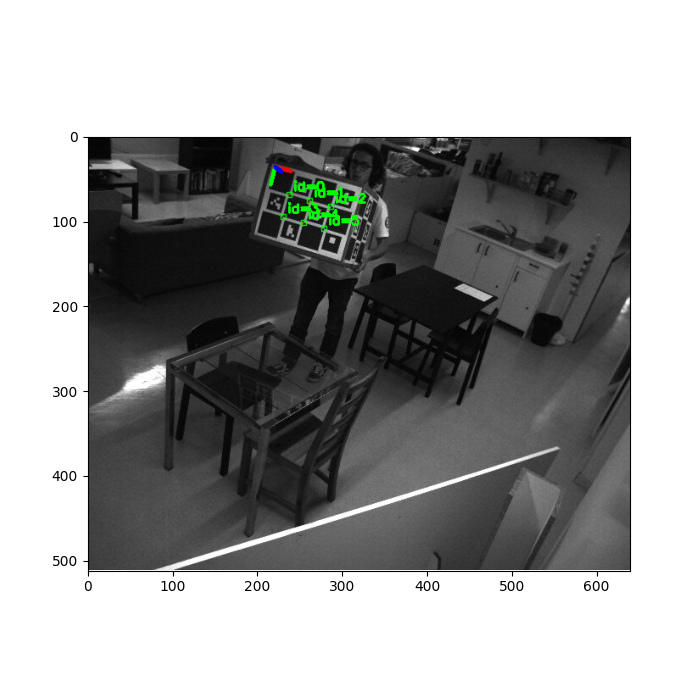

In [107]:
import cv2 as cv
from src.vican.vican.plot import detect_and_draw_charuco, detect_and_draw_aruco

%matplotlib widget

plt.figure(figsize=(7,7))

#im = detect_and_draw_aruco(dataset.im_data["filename"][204],
#                            'DICT_ARUCO_ORIGINAL',
#                            dataset.cams["0"],
#                            0,
#                            0)

im = detect_and_draw_charuco(dataset.im_data["filename"][74],
                            dataset.cams["0"],
                            charuco_dict)

#print(dataset.im_data["timestamp"][76])
    
im = cv.cvtColor(im, cv.COLOR_BGR2RGB)

plt.imshow(im)

# Calibrate object

In [143]:
if not LOAD:
    # This will compute camera-marker edges via PnP, in parallel
    aux = estimate_pose_mp(cams=obj_dataset.im_data['cam'],
                           im_filenames=obj_dataset.im_data['filename'],
                           target_dict = charuco_dict,
                           flags='SOLVEPNP_IPPE',
                           brightness=0,
                           contrast=0)
    
    pickle.dump(aux, open(os.path.join(OBJ_DATASET_PATH, 'cube_calib_pose.pkl'), 'wb'))
else:
    aux = pickle.load(open(os.path.join(OBJ_DATASET_PATH, 'cube_calib_pose.pkl'), 'rb'))
    print("Loaded")


Marker detection
Received 26 images.
Started pool of 8 workers.
Merging dictionaries...
Found markers in 26 images
Finished: 48 markers detected.


In [5]:
# Optimization - see extended paper

#print( aux.keys() )

obj_pose_est = object_bipartite_se3sync(aux,
                                        noise_model_r=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1,
                                        noise_model_t=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1,
                                        edge_filter=lambda edge : edge['reprojected_err'] < 10.0,
                                        maxiter=4,
                                        lsqr_solver="conjugate_gradient",
                                        dtype=np.float64)


Received graph with 30 nodes 48 edges
Applying constraints (0.017s).
Bipartite graph: 4 cameras, 26 timesteps, 48 edges.
Building 4x26 adjacency and 12x78 SO(3) sparse matrices (0.001s).
Building power graph (0.005s).


Optimizing:   0%|                                 | 0/4 [00:00<?, ?it/s]

Building sparse 144x90 incidence matrix (0.010s).
Solving sparse linear system (0.002s).
Done!


# object edges errors

0.53685504
0.299537


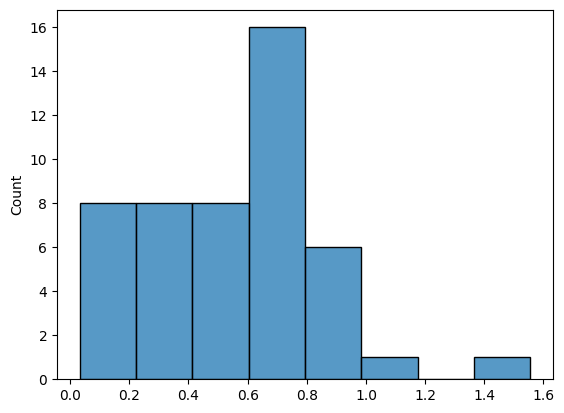

In [17]:
%matplotlib inline
# plot histogram of reprojected errors
sns.histplot([edge['reprojected_err'] for edge in aux.values()])

# print the mean and std of the reprojected errors
print(np.mean([edge['reprojected_err'] for edge in aux.values()]))
print(np.std([edge['reprojected_err'] for edge in aux.values()]))

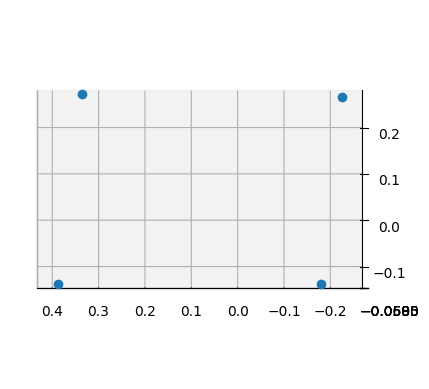

In [16]:
%matplotlib inline

xyz = np.stack([pose.t() for pose in obj_pose_est.values()], axis=0)
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=0, azim=90, roll=0)

ax.plot(xyz[:,0], xyz[:,1], xyz[:,2], 'o')
ax.set_aspect('equal')
plt.show()

# Detect markers & estimate camera-marker poses

In [144]:
if not LOAD:
    # This will compute camera-marker edges via PnP, in parallel
    cam_marker_edges = estimate_pose_mp(cams=dataset.im_data['cam'],
                                        im_filenames=dataset.im_data['filename'],
                                        target_dict=charuco_dict,
                                        flags='SOLVEPNP_IPPE',
                                        brightness=0,
                                        contrast=0)
    
    # Save it to use later, if necessary
    pickle.dump(cam_marker_edges, open(os.path.join(OBJ_DATASET_PATH, 'cam_marker_edges.pkl'), 'wb'))
else:
    cam_marker_edges = pickle.load( open(os.path.join(OBJ_DATASET_PATH, 'cam_marker_edges.pkl'), 'rb') )
    print("loaded")


Marker detection
Received 5814 images.
Started pool of 8 workers.


KeyboardInterrupt: 

In [ ]:
#count number of markers
marker_ids = []
for tuple, dictionary   in cam_marker_edges.items():
    if tuple[1].split('_')[1] == '0':
        print(tuple)
        

# cam_marker errors

0.19246922 0.1589015


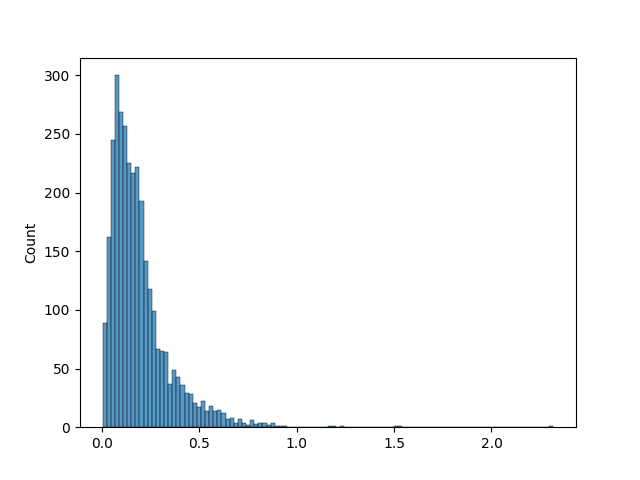

In [29]:
%matplotlib widget
plt.clf()
sns.histplot([edge['reprojected_err'] for edge in cam_marker_edges.values()])

# print the mean and std of the reprojected errors
print(np.mean([edge['reprojected_err'] for edge in cam_marker_edges.values()]),
      np.std([edge['reprojected_err'] for edge in cam_marker_edges.values()]))

plt.show()

# Optimization

In [83]:
pose_est = bipartite_se3sync(cam_marker_edges,
                            constraints=obj_pose_est,
                            noise_model_r=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1.0,
                            noise_model_t=lambda edge : 0.01 * Polygon(zip(edge['corners'][:,0], edge['corners'][:,1])).area**1.0,
                            edge_filter=lambda edge : edge['reprojected_err'] < 1.0,
                            maxiter=4,
                            lsqr_solver="conjugate_gradient",
                            dtype=np.float32)

Received graph with 2089 nodes 3153 edges
Applying constraints (0.211s).
Bipartite graph: 6 cameras, 966 timesteps, 2715 edges.
Building 6x966 adjacency and 18x2898 SO(3) sparse matrices (0.025s).
Building power graph (0.004s).


Optimizing:   0%|                                 | 0/4 [00:00<?, ?it/s]

Building sparse 9441x2916 incidence matrix (0.435s).
Solving sparse linear system (0.026s).
Done!


# Cameras D Plot

In [84]:
def plot_frame(ax, H, label):
    origin = H[:3, 3]
    x_axis = H[:3, 0]
    y_axis = H[:3, 1]
    z_axis = H[:3, 2]
    
    #origin = H[:3, 3]
    #x_axis = H[0, :3]
    #y_axis = H[1, :3]
    #z_axis = H[2, :3]

    ax.quiver(*origin, *x_axis, color='r', length=0.1, normalize=True)
    ax.quiver(*origin, *y_axis, color='g', length=0.1, normalize=True)
    ax.quiver(*origin, *z_axis, color='b', length=0.1, normalize=True)
    ax.text(*origin, label, fontsize=12, color='k')

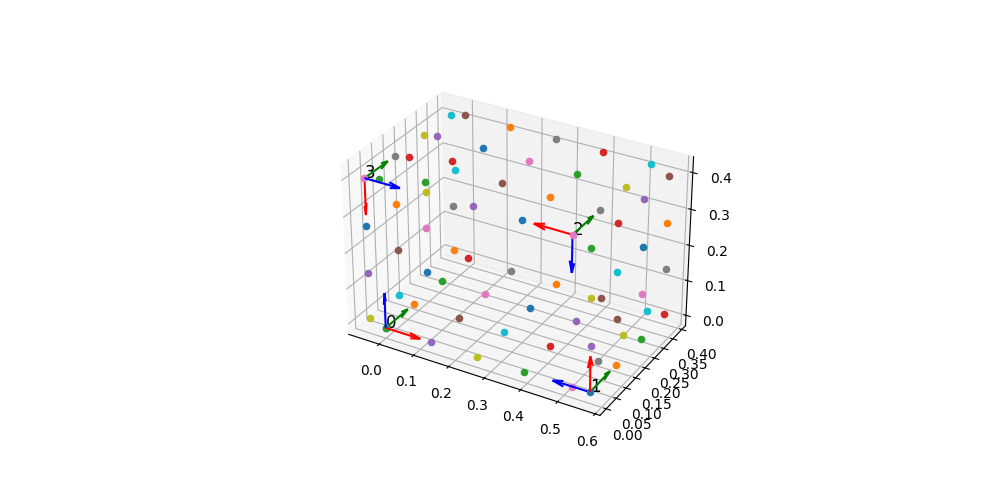

In [85]:
#%matplotlib inline
%matplotlib widget

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(projection='3d')

wrl_id = "0"
pts_wrld = []
for cam_id, pose in obj_pose_est.items():
    
    if ("_" in cam_id):
        continue
    
    plot_frame(ax, obj_pose_est[wrl_id].inv()._pose @ obj_pose_est[cam_id]._pose  , cam_id) # TODO: make a getter for the A matrix
    
    #draw the chessbaord corners in space for each charuco board
    for i in range(charuco_dict[cam_id]["sizeX"] + 1):
        for j in range(charuco_dict[cam_id]["sizeY"] + 1):
            if cam_id == "0":
                ax.scatter(i*charuco_dict[cam_id]["squareLength"], j*charuco_dict[cam_id]["squareLength"], 0)
                pts_wrld.append([i*charuco_dict[cam_id]["squareLength"], j*charuco_dict[cam_id]["squareLength"], 0])
                
            else:
                # transform the points to the "0" frame
                point = obj_pose_est[wrl_id].inv()._pose @ obj_pose_est[cam_id]._pose @  np.array([i*charuco_dict[cam_id]["squareLength"], j*charuco_dict[cam_id]["squareLength"], 0, 1])
                ax.scatter(point[0], point[1], point[2])
                pts_wrld.append(point[:3])



# draw the rest of the cube
ax.scatter(0,0,0)
# aspect ratio of the plot to be equal
ax.set_aspect('equal')

#ax.view_init(elev=0, azim=90, roll=0)
#make the plot interactive
plt.show()

pts_wrld = np.array(pts_wrld)
pts_wrld = np.vstack( [pts_wrld.T, np.ones(pts_wrld.shape[0]) ] )

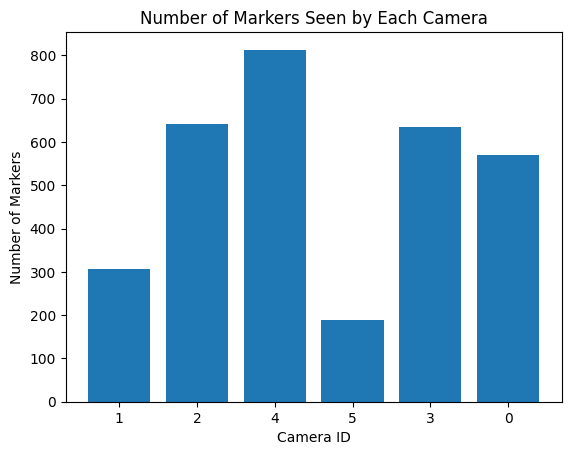

In [193]:

%matplotlib inline

import matplotlib.pyplot as plt

# Count the number of markers for each camera
marker_counts = {}
for cam_id, _ in cam_marker_edges.items():

    cam_id = cam_id[0]  # Extract the camera ID
    
    if cam_id in marker_counts:
        marker_counts[cam_id] += 1
    else:
        marker_counts[cam_id] = 1

# Create the histogram
plt.figure()
plt.bar(marker_counts.keys(), marker_counts.values())
plt.xlabel('Camera ID')
plt.ylabel('Number of Markers')
plt.title('Number of Markers Seen by Each Camera')
plt.show()

# Plot cameras in 3D Space

In [180]:
from src.vican.vican.geometry import SE3, rotz
from src.vican.vican.plot import plot_cams_3D

for cam_id, cam in dataset.cams.items():
    
    cam.extrinsics = pose_est[cam_id] 


plot_cams_3D(dataset.cams.values(), pose_est)

Saving to output.html


# Marker projected in image space after optimization

## Charuco list

In [120]:
charuco_list = []
for i in range(0,charuco_dict["num_boards"] + 1):
        
    charuco_board = cv.aruco.CharucoBoard(
        size=(charuco_dict[str(i)]["sizeX"], charuco_dict[str(i)]["sizeY"]),
        squareLength=charuco_dict[str(i)]["squareLength"],
        markerLength=charuco_dict[str(i)]["markerLength"],
        dictionary= cv.aruco.getPredefinedDictionary(charuco_dict[str(i)]["dictionary"]),
        ids=charuco_dict[str(i)]["ids"])
    
    charuco_board.setLegacyPattern(True)
    charuco_list.append(charuco_board)      
    
    
charuco_list[0]

< cv2.aruco.CharucoBoard 0x7f28a11e1a90>

## Projection

In [145]:
%matplotlib inline
for i in range(0, len(dataset.im_data["filename"])):
    
    timestep = dataset.im_data["timestamp"][i]
    cam_id = dataset.im_data["cam_id"][i]
    
    try:
        #xyz_0 into wrld frame
        xyz_wrl = pose_est[f"{timestep}_0"]._pose @ pts_wrld
    except:
        print("timestep not found")
        continue
    
    # k [ R^T | -R^T*t] = P
    cam_model = np.array( dataset.im_data["cam"][i].intrinsics
                         @ 
                         np.concatenate( ( pose_est[cam_id].R().T , -1 * pose_est[cam_id].R().T @ np.array([pose_est[cam_id].t()]).T ) , axis=1) )   # in camera frame
    
    # 3d points in marker0 frame into frame camera
    uv_0 = cam_model @ xyz_wrl
    
    # normalize homogenous coordinates
    uv_0 = uv_0[:2,:] / uv_0[2,:]

    im = cv.imread(dataset.im_data["filename"][i])
    
    #convert to gray
    #im = cv.cvtColor(im, cv.COLOR_BGR2GRAY)
    
    
    for board in charuco_list:
        
        corners, ids, rejected = cv.aruco.detectMarkers(im, board.getDictionary())
        if len(corners) > 0:
            retval, charuco_corners, charuco_ids = cv.aruco.interpolateCornersCharuco(corners, ids, im, board)
            if retval:
                for z in charuco_corners:
                    z =  z.squeeze()
                    
                    im = cv.circle(im, (int(z[0]), int(z[1])), 1, (0, 0, 255), 1)
    
    
    for j in range(uv_0.shape[1]):
        im = cv.circle(im, (int(uv_0[0,j]), int(uv_0[1,j])), 1, (0,255,0), 1)
    
    #im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
    
    cv.imwrite(f"test_images/{i}.png", im)

plt.figure(figsize=(12,12))
plt.imshow(im) 
plt.show()

KeyboardInterrupt: 

In [17]:
import open3d as o3d

# Load the PCD file
pc0 = o3d.io.read_point_cloud("dataset/pointcloud0.pcd")
pc1 = o3d.io.read_point_cloud("dataset/pointcloud1.pcd")
pc2 = o3d.io.read_point_cloud("dataset/pointcloud2.pcd")

triad = o3d.open3d.geometry.TriangleMesh.create_coordinate_frame()

# transform point clouds to world frame
pc0.transform(pose_est['0'].pose())
pc1.transform(pose_est['1'].pose())
pc2.transform(pose_est['2'].pose())

#merge all 3 point clouds and write them to a file
pc = pc0 + pc1 + pc2
o3d.io.write_point_cloud("dataset/pointcloud_merged.pcd", pc)

# Visualize the point cloud
o3d.visualization.draw_geometries([pc2,pc0, triad])

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


libGL error: MESA-LOADER: failed to retrieve device information
libGL error: MESA-LOADER: failed to open amdgpu: /usr/lib/dri/amdgpu_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri)
libGL error: failed to load driver: amdgpu
libGL error: failed to open /dev/dri/card0: No such file or directory
libGL error: failed to load driver: radeonsi


KeyboardInterrupt: 

In [14]:
position_list = []
for cam_id, pose in pose_est.items():
    if "_" in cam_id:
        continue
    position_list.append(pose_est[cam_id].t())
    print(np.linalg.det(pose_est[cam_id].R()))


print(position_list)


print(np.linalg.norm(position_list[0]- position_list[1]))
print(np.linalg.norm(position_list[1]- position_list[2]))
print(np.linalg.norm(position_list[2]- position_list[3]))
print(np.linalg.norm(position_list[2]- position_list[0]))

#print(cam_id)
#print(pose)
    

1.0
0.99999994
1.0
1.0
1.0000001
1.0
[array([-1.18432759,  1.14041572, -2.93590752]), array([ 3.26815264,  0.78810202, -2.73009251]), array([ 1.02800549,  1.17679071, -3.09868448]), array([-2.93013384, -1.08257921, -0.14741331]), array([-3.0659133 ,  1.01374456, -2.63940057]), array([ 3.60334255, -2.29933331,  1.75476159])]
4.471136878281489
2.3033015812077244
5.429698051471171
2.2186115410539786


# Writing JSON

In [ ]:
import json
json_data = {}
for cam_id, pose in pose_est.items():    
    #check if cam_id is a valid camera index
    if "_" in cam_id:
        continue
    json_data[int(cam_id)] = {'R': pose_est[cam_id].R().tolist(), 't': pose_est[cam_id].t().tolist()}
    
with open("pose_est.json", 'w') as f:
    json.dump(json_data, f, indent=4)

print("done")

done


In [ ]:
# get an array of 4 points in image frame and return the middle point
def get_middle_point(points):
    points = np.array(points)
    return np.mean(points, axis=0)


In [ ]:
cam_marker_edges

#dict with all marker_id and camera_id
data = {}



for (camera, time_marker) in cam_marker_edges:
    #print(cam_marker_edges[(camera, time_marker)])
    time, marker = time_marker.split("_")
    
    # make every field in dictionary be a list and keep appending
    if (marker, camera) not in data:
        data[marker, camera] = []

    data[marker, camera].append( get_middle_point(cam_marker_edges[(camera, time_marker)]['corners']).tolist() )    

lst_mrk_ids = [int(int_id) for int_id in MARKER_IDS]
# create a subplot for every dictionary entry
fig, axs = plt.subplots(len(dataset.cams),len(MARKER_IDS),  figsize=(50, 15))

for i, (marker, camera) in enumerate(data):
    ax = axs[int(camera) , int(marker)- min(lst_mrk_ids)]
    new_data = np.array(data[marker, camera])
    ax.hist2d(new_data[:,0], new_data[:,1], bins=50,
             range=np.array([(0, dataset.cams["0"].resolution_x), (0, dataset.cams["0"].resolution_y)]))
    ax.set_title(f"Camera {camera}, Marker {marker}")

NameError: name 'MARKER_IDS' is not defined

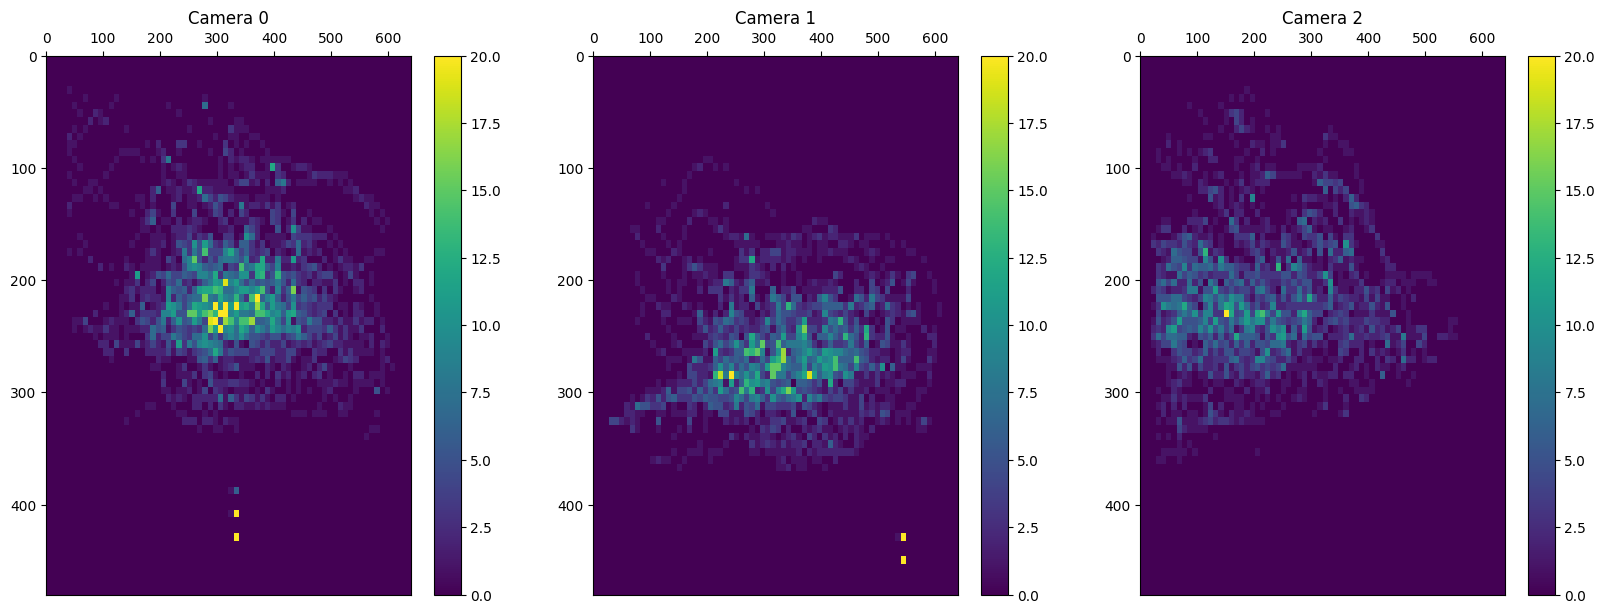

In [ ]:
dict_merge_mrks = {}
for field in data.keys():
    
    if field[1] not in dict_merge_mrks:
        dict_merge_mrks[field[1]] = []
        
    dict_merge_mrks[field[1]].append(data[field])


dict_merge_mrks.keys()

fig, axs = plt.subplots(1, len(dataset.cams),  figsize=(20,7))

for i, camera in enumerate(dict_merge_mrks):
    ax = axs[int(camera)]
    new_data = np.concatenate(dict_merge_mrks[camera], axis=0)
    h = ax.hist2d(new_data[:,0], new_data[:,1], bins=70,
                 range=np.array([(0, dataset.cams["0"].resolution_x), (0, dataset.cams["0"].resolution_y)]),
                 vmin=0, vmax=20)  
    a = plt.colorbar(h[3], ax=ax)
    #a.set_ticks([-1, 0, 1])

        
    ax.set_title(f"Camera {camera}")
    ax.xaxis.set_ticks_position('top')
    ax.invert_yaxis()



    